# VAR MODEL

1) read microbiome feature table (rows: timsteps, cols: OTUs)
2) transform it with CLR (get data out of the simplex)
3) filter dataframe removing rare OTU's
4) VAR_predict_train_rolling()  :  fit VAR model on train set and predict on train set using rolling cross validation
5) VAR_predict_test_rolling()   :  fit VAR model on train set and predict on test set using rolling cross validation
6) VAR_predict_train_shuffled() :  fit VAR model on train set and predict on train set using shuffled cross validation
7) VAR_predict_test_shuffled()  :  fit VAR model on train set and predict on test set using shuffled cross validation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
import warnings
import numpy as np
import seaborn as sns
import random
import os
import sys


from scipy.special import logsumexp
from statsmodels.tsa.api import VAR, VECM
import sklearn.metrics as skm
import statsmodels.api as sm

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from utils.measures import calculate_nrmse, calculate_spearman, inter_dissimilarity 
from utils.transformers import CLRTransformer

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. READ DATA

In [4]:
file_donorA = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/donorA_rarefied_interpolated_feces.csv'

In [5]:
df = pd.read_csv(file_donorA, index_col = 0)

<AxesSubplot:ylabel='Density'>

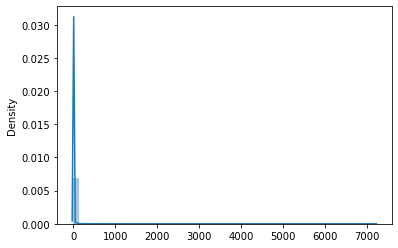

In [6]:
sns.distplot(df)

### 2. TRANSFORM DATA USING CLR

In [7]:
clr_transformer = CLRTransformer(is_pseudo_global=True, axis=1)
df_clr = clr_transformer.fit_transform(df)

<AxesSubplot:ylabel='Density'>

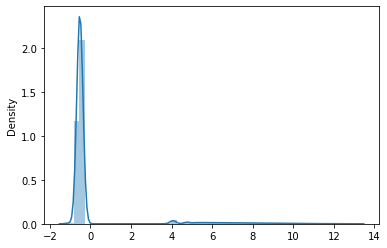

In [8]:
sns.distplot(df_clr)

### 3. FILTER RARE BACTERIA

In [55]:
def filter_out_rare_bacteria(df, n_bacteria=100):
    
    ''' 
    sort bacteria by their mean abundance and keep n 
    most common bacteria 
    '''
    
    n_bacteria = n_bacteria

    rare_bacteria_df = pd.DataFrame(df.describe().iloc[1])
    common_bacteria = rare_bacteria_df.sort_values(by = ['mean']).tail(n_bacteria).index
    df_filtered = df[common_bacteria]
    
    return df_filtered

In [57]:
df_clr_filtered = filter_out_rare_bacteria(df_clr)
df_filter = df[df_clr_filtered.columns]

<AxesSubplot:ylabel='Density'>

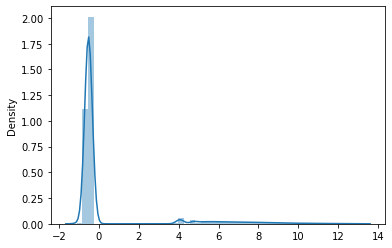

In [50]:
sns.distplot(df_clr_filtered)

### FIT VAR MODEL ON TRAIN MODEL

In [51]:
# define x_train and x_test
split = int(df_clr_filtered.shape[0] * 0.1) #10% going to test set

x_train = df_clr_filtered[:-split].values
x_test = df_clr_filtered[-split:].values

x_train.shape, x_test.shape

((329, 1000), (36, 1000))

In [52]:
def VAR_predict_train_rolling(x_train, lag=1, steps=1):
    
    ''' 
    fit VAR model on train set and predict 
    on train set using rolling cross validation
    
    Params
    ---------
    x_train    : np.array with train data
    lag        : lag to use in VAR model
    steps      : forecast horizon
    
    Returns
    ---------
    model_fit: fitted model object
    predictions_array: array with predictions on 
                 train set
    '''
    
    lag = lag

    model = VAR(x_train)
    model_fit = model.fit(lag) #fit model

    history_train =  [x for x in x_train[:lag]]
    predictions = list()

    # rolling cross validation loop
    for i in range(lag, len(x_train)):
        #get last train timestep as input for the forecast

        yhat = model_fit.forecast(y=x_train[-lag:], steps=steps) #forecast
        predictions.append(yhat)

        obs = x_train[i]
        history_train.append(obs)
        
    predictions_array = [item for sublist in predictions for item in sublist]

    return model_fit, predictions_array

In [53]:
fitted_model, train_predictions = VAR_predict_train_rolling(x_train, lag = 5)

In [54]:
len(train_predictions)

324

### FIT MODEL ON TEST DATA ROLLING CV

In [14]:
def VAR_predict_test_rolling(x_train, x_test, lag=1, steps=1):
    
    ''' 
    fit VAR model on train set and predict 
    on test set using rolling cross validation
    
    Params
    ---------
    x_train    : np.array with train data
    x_test     : np.array with test data
    lag        : lag to use in VAR model
    steps      : forecast horizon
    
    Returns
    ---------
    model_fit        : fitted model object
    predictions_array: array with predictions on the
                 test set
    '''
        
    
    lag = lag

    model = VAR(x_train)
    model_fit = model.fit(lag)

    history = [x for x in x_train]
    predictions = list()
    #get last train timestep as input for the forecast
    forecast_input = x_train[-lag:]
    #make 1st forecast
    yhat = model_fit.forecast(y=forecast_input, steps=1)

    #append to predictions
    predictions.append(yhat)
    #add first value from test to train 
    history.append(x_test[0]) 

    for i in range(1, len(x_test)):

        #fit model
        model = VAR(history)
        model_fit = model.fit(lag)
        
        forecast_input = np.array(history[-lag:])
        yhat = model_fit.forecast(y=forecast_input, steps=1)
        predictions.append(yhat)

        obs = x_test[i]
        history.append(obs)
        
    predictions_array = [item for sublist in predictions for item in sublist]

    return model_fit, predictions_array

In [30]:
fitted_model, predictions_test_rolling = VAR_predict_test_rolling(x_train, x_test)

In [19]:
def VAR_predict_test_shuffled(x_train, x_test,lag=1, steps=1):

    '''
    Use fitted VAR model to make predictions
    on test data in a shuffled manner (use random days,
    do not care about order)

    Params
    ------
    x_train: np.array
    x_test : np.array
    fitted_model: fitted VAR model
    steps: forecast horizon

    Returns
    ------
    predictions_df 

    '''
    
    lag = lag

    model = VAR(x_train)
    fitted_model = model.fit(lag)
    
    predictions = []

    forecast_input = x_train[-1].reshape(steps, len(x_train[-1])) 
    yhat = fitted_model.forecast(y=forecast_input, steps=steps)
    predictions.append(yhat)

    random_idx = list(range(len(x_test) - 1)) 
    random.Random(10).shuffle(random_idx)

    for i in random_idx:
        forecast_input = x_test[i].reshape(steps, len(x_test[i]))
        yhat = fitted_model.forecast(y=forecast_input, steps=steps)
        predictions.append(yhat)

    predictions_array = [item for sublist in predictions for item in sublist]
    predictions_df = pd.DataFrame(predictions_array)

    idx = [0] + [x+1 for x in random_idx]
    predictions_df.index = idx 
    predictions_df = predictions_df.sort_index()

    return predictions_df   

In [29]:
predictions_test_shuffled = VAR_predict_test_shuffled(x_train, x_test)
predictions_test_shuffled.index = df_clr_filtered.iloc[-split:].index

In [20]:
def VAR_predict_train_shuffled(x_train, lag=1, steps=1):

    '''
    Use fitted VAR model to make predictions
    on test data in a shuffled manner (use random days,
    do not care about order)

    Params
    ------
    x_train: np.array
    x_test : np.array
    fitted_model: fitted VAR model
    steps: forecast horizon

    Returns
    ------
    predictions_df 

    '''
    lag = lag

    model = VAR(x_train)
    fitted_model = model.fit(lag)
    
    
    predictions = []

    random_idx = list(range(len(x_train) - 1)) 
    random.Random(10).shuffle(random_idx)

    for i in random_idx:
        forecast_input = x_train[i].reshape(steps, len(x_train[i]))
        yhat = fitted_model.forecast(y=forecast_input, steps=steps)
        predictions.append(yhat)

    predictions_array = [item for sublist in predictions for item in sublist]
    predictions_df = pd.DataFrame(predictions_array)

    idx = [x+1 for x in random_idx]
    predictions_df.index = idx 
    predictions_df = predictions_df.sort_index()

    return predictions_df   

In [28]:
predictions_train_shuffled = VAR_predict_train_shuffled(x_train)
predictions_train_shuffled.index = df_clr_filtered.iloc[1:-split].index

In [ ]:
pred_inv = np.exp(predictions_df) * clr_transformer.gmean_[-split:, None]

In [ ]:
true_test = df_filtered[-split:]
for i in range(1, 20):
    sns.lineplot(x = range(len(true_test)), y = true_test.iloc[:, i], color = 'black')
    sns.lineplot(x = range(len(pred_inv)), y = pred_inv.iloc[:, i], color = 'orange')
    plt.ylabel('')
    plt.show()